Link to the essay: https://drive.google.com/file/d/1EhOQVQAZamRgIs7JiiZZx4mZtML8TfjP/view?usp=sharing

## Parts 1 and 2 ##

In [1]:
import pymupdf
import re
from nltk.tokenize import sent_tokenize

def parse_file(file):
    # converting pdf to python str page by page
    pdf = pymupdf.open(file)
    sentences = []
    for page_num in range(10):
        page = pdf[page_num]
        text_from_page = page.get_text().replace("ﬁ", "fi").replace("ﬂ", "fl").replace("\n", " ") # replace f-ligaments according to advice in chat
        text_from_page = re.sub("\s{2,}", " ", text_from_page) # getting rid of extra spaces
        text_from_page = re.sub("\s\.", ".", text_from_page) # getting rid of extra spaces before full stops
        text_in_sentences = sent_tokenize(text_from_page)
        for sentence in text_in_sentences:
            # collecting all text in sentences
            sentences.append(sentence)
    return sentences

In [2]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# this model captures the most semantic correlations out of all pretrained models of this module
model = SentenceTransformer('all-mpnet-base-v2')
article_in_sent = parse_file("Neural Networks Fail.pdf")

C:\Users\Алексей\AppData\Roaming\Python\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
Using TensorFlow backend.
C:\Users\Алексей\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Part 3 ##

In [3]:
import numpy as np

# creating embeddings
embeddings = np.zeros((306, 768), dtype='float32')
for i, sentence in tqdm(enumerate(article_in_sent)):
    try:
        embeddings[i] = np.array(model.encode(sentence))
    except Exception:
        continue

306it [00:28, 10.82it/s]


## Part 4 ##

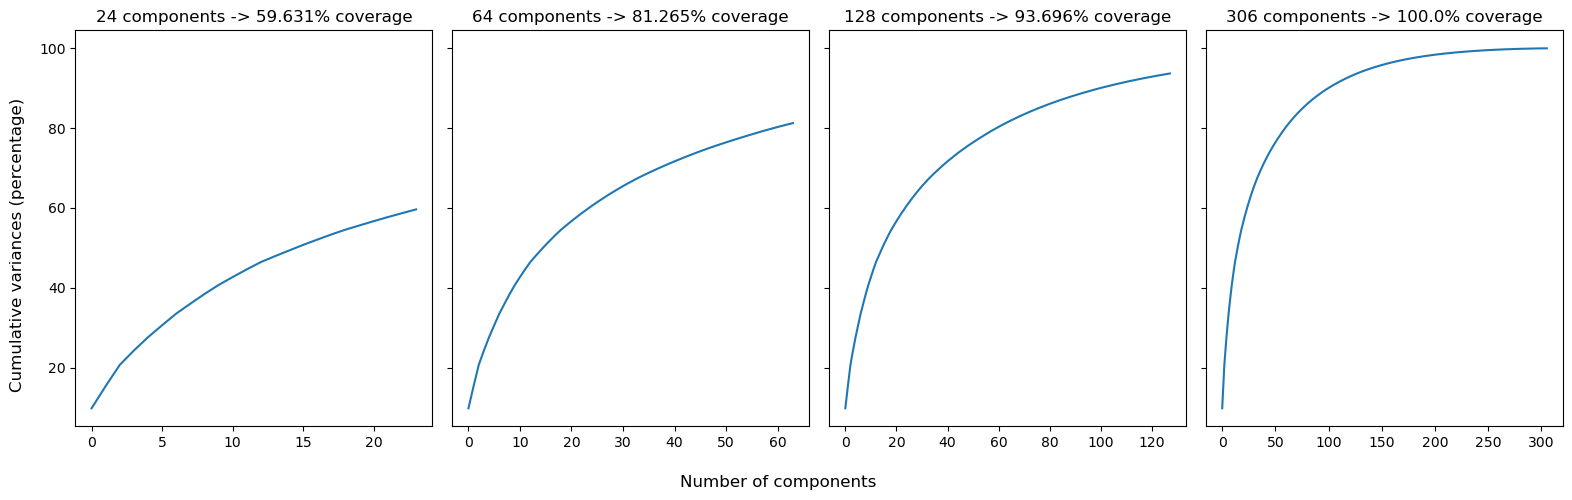

In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

components_list = [24, 64, 128, 306]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 5), sharey=True)
for i, components in enumerate(components_list):
    pca = PCA(components)
    pca.fit(embeddings)
    cum_variances = pca.explained_variance_ratio_.cumsum() * 100
    axs[i].set_title(f"{components} components -> {round(float(cum_variances[-1]), 3)}% coverage")
    axs[i].plot(cum_variances)
fig.supxlabel("Number of components")
fig.supylabel("Cumulative variances (percentage)")
fig.tight_layout(rect=[0.01, 0, 1, 1])
plt.show()

Since 306d embeddings capture all variance, I decided to use them as the base embeddings

## Part 5 ##

By testing I found out that 128d embeddings act practycally same as 64d.

I want to focus readers attention not only on 64d embeddings, but on 24d ones, since they are pretty slim, but still are accurate and ready for use.

In [50]:
import faiss

def create_search_base(n_components):
    pca = PCA(n_components=n_components)
    pca_embeddings = pca.fit_transform(embeddings)
    index = faiss.IndexFlatL2(n_components)
    index.add(pca_embeddings)
    return pca, index


pca_24, index_24 = create_search_base(24)
pca_64, index_64 = create_search_base(64)
pca_306, index_306 = create_search_base(306)

## Part 6 ##

In [51]:
def top_n_similar(query, n, pca, index):
    embedding = pca.transform(np.array(model.encode(query)).reshape(1, -1))
    distances, indices = index.search(embedding, n)
    return distances, np.array(article_in_sent)[indices.flatten()]

def iou(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

search_query = 'periodic function'
number_of_sent_in_top = 10
euc_dist_24, top_24 = top_n_similar(search_query, number_of_sent_in_top, pca_24, index_24)
euc_dist_64, top_64 = top_n_similar(search_query, number_of_sent_in_top, pca_64, index_64)
euc_dist_306, top_306 = top_n_similar(search_query, number_of_sent_in_top, pca_306, index_306)
print(f"Intersection over Union (24 and 64): {iou(top_24, top_64)}")
print(f"Intersection over Union (24 and 306): {iou(top_24, top_306)}")
print(f"Intersection over Union (64 and 306): {iou(top_64, top_306)}")

Intersection over Union (24 and 64): 0.8181818181818182
Intersection over Union (24 and 306): 0.6666666666666666
Intersection over Union (64 and 306): 0.8181818181818182


In [52]:
# if you want to look at the sentences themselves

#for i in range(number_of_sent_in_top):
#    print(top_128[i])
#    print(top_306[i])
#    print()

In [54]:
from Levenshtein import distance

lev_dist_24 = []
lev_dist_64 = []
lev_dist_306 = []
for i in range(number_of_sent_in_top):
    lev_dist_24.append(distance(top_24[i], search_query))
    lev_dist_64.append(distance(top_64[i], search_query))
    lev_dist_306.append(distance(top_306[i], search_query))

In [55]:
import polars as pl

df = pl.DataFrame({"Top from embeddings of 24d": top_24, "Top from embeddings of 64d": top_64, "Top from embeddings of 306d": top_306, "Euclidian distance (24)": euc_dist_24[0], "Euclidian distance (64)": euc_dist_64[0], "Euclidian distance (306)": euc_dist_306[0], "Levenshtein distance (24)": lev_dist_24, "Levenshtein distance (64)": lev_dist_64, "Levenshtein distance (306)": lev_dist_306})
df

Top from embeddings of 24d,Top from embeddings of 64d,Top from embeddings of 306d,Euclidian distance (24),Euclidian distance (64),Euclidian distance (306),Levenshtein distance (24),Levenshtein distance (64),Levenshtein distance (306)
str,str,str,f32,f32,f32,i64,i64,i64
"""With a period …","""With a period …","""With a period …",0.115665,0.24046,0.489691,65,65,65
"""1 Introduction…","""1 Introduction…","""1 Introduction…",0.222319,0.350161,0.556747,445,445,445
"""Being able to …","""Being able to …","""Being able to …",0.274481,0.411475,0.622427,135,135,135
"""If we know bef…","""This shows tha…","""This shows tha…",0.292318,0.469308,0.741187,124,118,118
"""This shows tha…","""If we know bef…","""If we know bef…",0.314095,0.495444,0.790039,118,124,124
"""It is hence li…","""In such cases …","""In such cases …",0.350003,0.50033,0.795602,161,175,175
"""Learning a per…","""Learning a per…","""It is hence li…",0.363276,0.527265,0.798999,153,153,161
"""In terms of ap…","""It is hence li…","""Learning a per…",0.368876,0.528439,0.813753,128,161,153
"""In such cases …","""In terms of ap…","""We also hope t…",0.372455,0.53575,0.844765,175,128,111


To conclude, I got the impression that 64d embeddings work as well as the original ones, for this article, and even 24d embeddings are quite good.